# Predict layout of simulated chess board

In [6]:
import os.path as osp

import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as Tf

from pydrake.perception import PointCloud

from chess_bot.stations.board_perception_station import PerceptionStation

import plotly.express as px
from plotly.graph_objs import Scatter
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go

import trimesh

from pydrake.all import (
    BaseField, 
    Fields, 
    PointCloud,
    RigidTransform,
    RotationMatrix,
    
)

from scipy import ndimage, misc
import matplotlib.pyplot as plt

from chess_bot.perception.icp import icp

from chess_bot.utils.plotly_utils import multiplot
from chess_bot.resources.board import Board
from chess_bot.utils.path_util import get_chessbot_src

In [7]:
pieces_to_pcds = {
    'B' : 'Bishop',
 
    'K' : 'King',
 
    'N' : 'Knight',
 
    'P' : 'Pawn',
 
    'Q' : 'Queen',
 
    'R' : 'Rook',
}

In [8]:
per_station = PerceptionStation()

## Generate a new board
Generate a board, then show an image of the board.  Also produces a stack of
pointclouds generated from the rgbd sensor and mask r-cnn

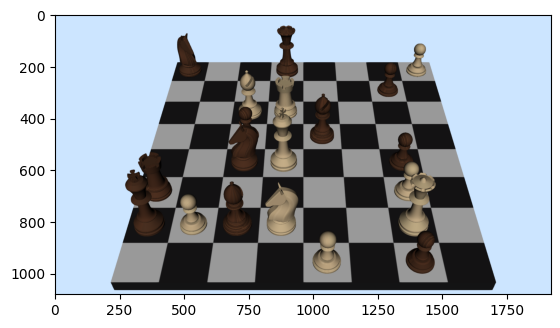

In [9]:
per_station.set_arbitrary_board(20)
color_image, depth_image, label_image = per_station.read_rgbd_sensor()
images = per_station.station.GetOutputPort('camera_masked_depth_image').Eval(per_station.station_context)
pcd_stack, pieces = per_station.station.GetOutputPort('camera_pcd_stack').Eval(per_station.station_context)
image = Image.fromarray(np.uint8(color_image)).convert('RGB')
plt.imshow(image)

## Run ICP 
Run ICP to convert partial point clouds into full pointclouds of pieces

In [10]:
want = {'B', 'N'}
icp_pieces = []
raw_pieces = []
print('pcds: ', len(pcd_stack))
for i in range(len(pcd_stack)):
    pcd = pcd_stack[i]
    piece = pieces[i][0]  # First char is piece type
    # if piece not in want:
    #     continue

    # print(piece)
    xyzs = pcd.xyzs()
    # print(xyzs.shape)

    rand_transform = RigidTransform(RotationMatrix.MakeXRotation(np.pi/6), [-.1, .1, .1])


    fn = osp.join(get_chessbot_src(), f'resources/reference_pcds/{pieces_to_pcds[piece]}.npy')
    # model = np.load(f'../reference_pcds/{pieces_to_pcds[piece]}.npy').T
    model = np.load(fn).T
    # model = xyzs
    # print(model.shape)
    scene = xyzs
    model = model[:, :xyzs.shape[1]]  # Make model and scene the same size
    # print(model.shape)
    # scene = rand_transform.multiply(xyzs) 
    X_sceneModel, _, _ = icp(scene, model, max_iterations=30, tolerance=1e-5)
    # X_sceneModel

    # fig = multiplot([model.T, scene.T])
    icp_pieces.append(X_sceneModel.multiply(model).T)
    raw_pieces.append(scene.T)
    # fig = multiplot([X_sceneModel.multiply(model).T, scene.T, model.T])
    # iplot(fig)
    # break

# fig = multiplot([pcd.T for pcd in icp_pieces] + [pcd.T for pcd in raw_pieces])
fig = multiplot(icp_pieces)
iplot(fig)
fig = multiplot(raw_pieces)
iplot(fig)


pcds:  20


In [11]:
def extract_piece_locations(pcds: list[np.ndarray], pieces: list[str]) -> list:
    """
    Get piece locations from raw pointclouds.  list of (location, piece) pairs

    Args:
        pcds (list(np.ndarray)): list of pcds in N x 3 format
        pieces (list(str)): list of predicted piece types

    Returns:
        list: (location, piece) tuples where location is (x, y) position in meters
    """
    res = []
    for i, pcd in enumerate(pcds):
        mean_loc = list(np.mean(pcd[:, :2], axis=0))
        res.append((mean_loc, pieces[i]))
    return res

extract_piece_locations(icp_pieces, pieces)

[([-0.10275820940617904, -0.15331448079535048], 'PW'),
 ([-0.22213577310899604, -0.15837431197975044], 'PB'),
 ([0.16132188579679155, -0.15896410933322405], 'PB'),
 ([-0.2222238956128149, -0.031395909761990734], 'PW'),
 ([-0.031576629415414635, -0.1584915481000035], 'PB'),
 ([-0.15840013955191284, 0.15884049553442703], 'PW'),
 ([-0.02841380324244409, 0.09299845158389002], 'NB'),
 ([0.22195631463343585, -0.22197977331343982], 'PW'),
 ([-0.15811672725099335, 0.029144763596340658], 'NW'),
 ([-0.09507206195247474, 0.2222844259038538], 'RB'),
 ([0.031170955023877418, 0.09500284594218152], 'PB'),
 ([-0.15636868957890468, 0.09532355710956436], 'BB'),
 ([0.09898323729937142, 0.09492812094174169], 'BW'),
 ([0.034055842474643945, -0.03159534771880251], 'BB'),
 ([-0.027890998354524934, 0.032221650643688184], 'KW'),
 ([0.22230609874146767, 0.22141428940275634], 'NB'),
 ([0.0979595206840205, 0.03169435863054536], 'RW'),
 ([-0.15814090963752256, 0.22267266401724745], 'KB'),
 ([0.2219177642035723, 0.

['  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ']
['  ', '  ', '  ', '  ', 'PW', '  ', 'BW', '  ']
['PW', '  ', 'PB', '  ', '  ', 'PW', 'RW', '  ']
['  ', 'RB', 'PW', '  ', '  ', 'PB', '  ', '  ']
['BB', 'QW', '  ', '  ', '  ', '  ', 'BW', '  ']
['  ', 'PB', '  ', 'PW', 'PB', 'NB', '  ', '  ']
['  ', '  ', '  ', 'PW', '  ', '  ', '  ', '  ']
['  ', '  ', 'NB', '  ', '  ', 'PW', 'PB', '  ']


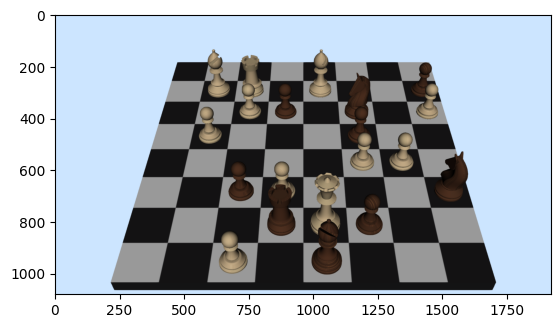

In [22]:
res_board = Board()
coords_piece = extract_piece_locations(icp_pieces, pieces)

res = [['  ' for i in range(8)] for j in range(8)]
for i in range(len(coords_piece)):
    coord = coords_piece[i][0]
    piece = coords_piece[i][1]
    loc = res_board.coord_to_location(coord)
    # print(loc)
    res[7-loc[1]][loc[0]] = piece

for line in res:
    print(line)
# print(res)
# print(piece)
# print(loc)
plt.imshow(image)

In [ ]:
i = 10
pcd_np = pcd_stack[i]
print(type(pcd_np))
N = pcd_np.shape[0]
pcd = PointCloud(N, Fields(BaseField.kXYZs | BaseField.kRGBs))
pcd.mutable_xyzs()[:] = pcd_np.T
pcd_np = pcd.VoxelizedDownSample(voxel_size=0.002).xyzs().T

print(pcd_np.shape)




        # N = spatial_points.shape[1]
        # pcd.append(PointCloud(N, Fields(BaseField.kXYZs | BaseField.kRGBs)))
        # pcd[-1].mutable_xyzs()[:] = spatial_points
        # pcd[-1].mutable_rgbs()[:] = rgb_points
        # # Estimate normals
        # pcd[-1].EstimateNormals(radius=0.1, num_closest=30)
        # # Flip normals toward camera
        # pcd[-1].FlipNormalsTowardPoint(X_WC.translation())

<class 'numpy.ndarray'>
(1204, 3)


In [ ]:
# https://stackoverflow.com/questions/41323423/plotly-inside-jupyter-notebook-python
init_notebook_mode(connected=True)         # initiate notebook for offline plot

# pcd_np = pcd_stack
# # pcd_np = pcd_np[~np.isinf(pcd_np).any(axis=1), :]
# # pcd_np = pcd_np[~np.isnan(pcd_np).any(axis=1), :]
# print(pcd_np.shape)

n_samples = 10000
idxs = np.random.randint(0, len(pcd_np), (n_samples))
sample = pcd_np[idxs, :]


# pcd = trimesh.PointCloud(pcd_np)
# pcd_np = pcd.sam
# print(pcd_np.shape)

fig = px.scatter_3d()

fig.add_trace(go.Scatter3d(
    x=sample[:, 0], y=sample[:, 1], z=sample[:, 2],
    mode='markers', 
    marker=dict(color='rgba(255, 106, 100, 1.0)', size=1)
))

fig.update_layout(scene_aspectmode='data')


# trace0 = Scatter(
#   x=[1, 2, 3, 4],
#   y=[10, 15, 13, 17]
# )
# trace1 = Scatter(
#   x=[1, 2, 3, 4],
#   y=[16, 5, 11, 9]
# )

iplot(fig)

(1080, 1920, 4)


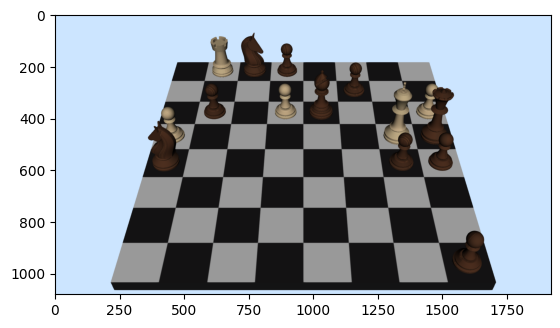

In [ ]:
i = 2
per_station.set_arbitrary_board(15)
per_station.read_rgbd_sensor()
images = per_station.station.GetOutputPort('camera_masked_depth_image').Eval(per_station.station_context)

image = images[i]
print(image.shape)
image = Image.fromarray(np.uint8(image)).convert('RGB')
plt.imshow(image)